In [71]:
import numpy as np
from scipy.stats import multivariate_normal as mvn
import matplotlib.pylab as plt
import sys
from trajectory import trajectory
np.set_printoptions(precision=2)

# Particle filter: Constant velocity model podruhé

Cílem tohoto cvičení je filtrace polohy objektu pohybujícího se na ploše, tj. ve 2D, tentokrát ale particle filtrem. Model je lineární a PF tak přinese jen zvýšené výpočetní nároky oproti KF, nicméně jako vstup do světa particle filtrace je to dobré cvičení.

Připomeňme, že cílem je odhadovat stavový vektor sestávající se z polohy v osách $x_1$ a $x_2$ a rychlostech v obou těchto osách.

$$
x_t =
\begin{bmatrix}
x_{1,t} \\ 
x_{2,t} \\ 
v_{x_1,t} \\ 
v_{x_2,t}
\end{bmatrix}
$$

Víme, že pro polohu v první ose platí

$$
x_{1,t} = x_{1,t-1} + v_{x_1,t} dt + w_{x_1,t},
$$

a že analogicky platí totéž i pro polohu v ose druhé. Abychom se nemuseli zaobírat zrychlením, budeme uvažovat, že rychlost je stejná a její změny jsou způsobeny jen šumem,

$$
v_{x_1,t} = v_{x_1, t-1} + w_{vx_1, t}.
$$

Analogicky pro druhou složku rychlosti. K dispozici jsou jen měření polohy v obou osách a to v časovém kroku 1s.

Potřebujeme tedy sestavit stavový model

$$
\begin{aligned}
x_t &\sim \mathcal{N}(Ax_{t-1} + Bu_t, Q),\\
y_t &\sim \mathcal{N}(Hx_{t}, R).
\end{aligned}
$$

Kovarianční matice nám musí někdo dodat, níže jsou uvedeny.

\begin{align*}
    A &=
    \begin{bmatrix}
       1 & 0 & dt & 0 \\
       0 & 1 & 0 & dt \\
       0 & 0 & 1 &  0 \\
       0 & 0 & 0 &  1 
    \end{bmatrix},
    \quad
    &Q &= q\cdot
    \begin{bmatrix}
        \frac{dt^3}{3}    & 0                 & \frac{dt^{2}}{2}  & 0  \\
        0                 & \frac{dt^3}{3}    & 0                 & \frac{dt^{2}}{2} \\
        \frac{dt^{2}}{2}  & 0                 & dt                & 0 \\
        0                 & \frac{dt^{2}}{2}  & 0                 & dt
    \end{bmatrix}
    \notag \\
    H &=
    \begin{bmatrix}
        1 & 0 &0 & 0 \\
        0 & 1 &0 & 0
    \end{bmatrix}
    \quad
    &R &=
    r^{2}\cdot
    \begin{bmatrix}
        1 & 0 \\
        0 & 1
    \end{bmatrix}
\end{align*}

kde $dt = 1$, $q = .5$, $r=3$.

In [72]:
q = .5
dt = 1.
r = 3.
A = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt],
              [0, 0, 1,  0],
              [0, 0, 0,  1]])
Q = q * np.array([[dt**3/3, 0      , dt**2/2, 0      ],
                  [0,       dt**3/3, 0,       dt**2/2],
                  [dt**2/2, 0,       dt,      0      ],
                  [0,       dt**2/2, 0,       dt     ]])
H = np.array([[1., 0, 0, 0],
              [0., 1, 0, 0]])
R = r**2 * np.eye(2)

**Vykreslíme si sledovanou polohu křížky.**

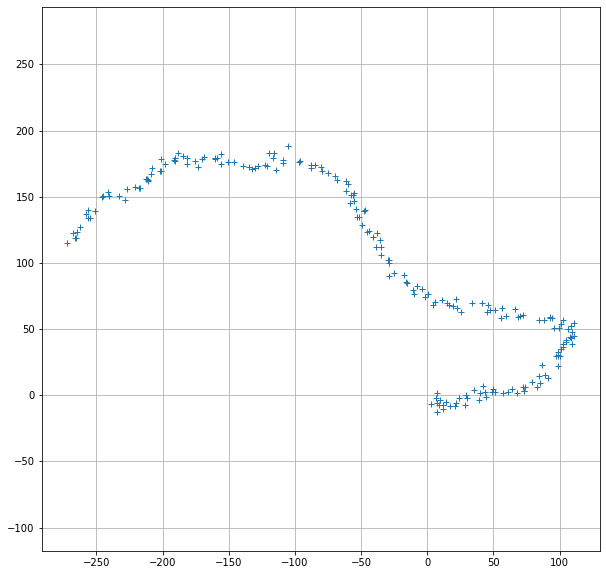

In [73]:
code = 656
traj = trajectory(code)
plt.figure(figsize=(10, 10))
plt.plot(traj.Y[0,:], traj.Y[1,:], '+')
plt.axis('equal')
plt.show()

**Úkol: Dodefinujte proposal distribuci a nasimulujte z ní `nsamples` vzorků. Proposal bude N(0, 10I)**

In [112]:
ndat = traj.ndat
nsamples = 100
proposal_loc = np.zeros(4) +10
proposal_cov = 1. * np.eye(4)

samples_x = mvn.rvs(mean=proposal_loc, cov=proposal_cov, size=nsamples)
weights = np.ones(nsamples)
weights /= weights.sum()
print("Kontrola vah: 1 =", weights.sum())

Kontrola vah: 1 = 0.9999999999999999


**Úkol: doplňte funkce**

In [113]:
# Logs
log_x = np.zeros((4, ndat))

def prediction(samples_x):
    samples_x_new = np.zeros_like(samples_x)
    for i in range(nsamples):
        mean = A.dot(samples_x[i])
        samples_x_new[i] = mvn.rvs(mean=mean, cov=Q)
    return samples_x_new

def update(yt, samples_x, weights):
    for i in range(nsamples):
        mean = H.dot(samples_x[i])
        likelihood = mvn.pdf(yt, mean=mean, cov=R)
        weights[i] *= likelihood
    weights /= weights.sum()
    return weights

def resample(samples_x, weights):
    indices = np.random.choice(np.arange(weights.size), replace=True, p=weights, size=weights.size)
    samples_x_new = samples_x[indices]
    weights = np.ones_like(weights)/weights.size
    return [samples_x_new, weights]

**Zkusíme pustit filtr. Dodefinujte `estimate` - bude to bodový odhad.**

In [114]:
for t, yt in enumerate(traj.Y.T):
    
    # Resampling
    samples_x, weights = resample(samples_x, weights)
    
    # Prediction
    samples_x = prediction(samples_x)

    # Update
    if t<90 or t>110:
        weights = update(yt, samples_x, weights)
    
    # Estimate & log
    estimate = np.sum(samples_x * weights[:,np.newaxis], axis=0)
    log_x[:,t] = estimate

### Výsledky: 

**1. Poloha - měření, skutečnost a odhad:**

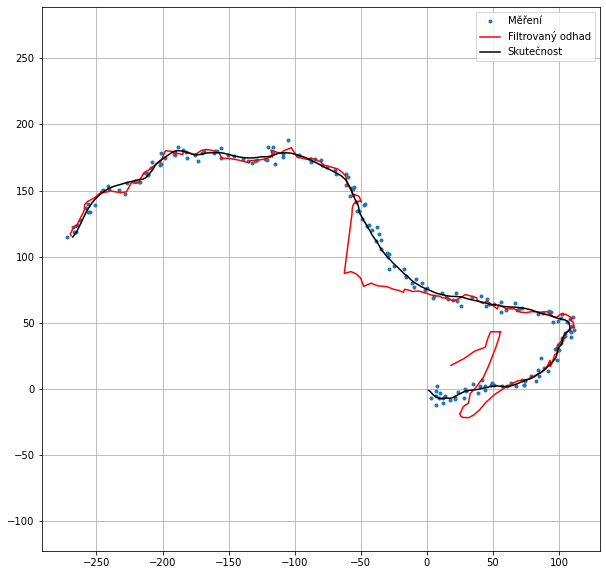

In [115]:
plt.figure(figsize=(10,10))
plt.plot(traj.Y[0,:], traj.Y[1,:], '.', label='Měření')
plt.plot(log_x[0,:], log_x[1,:], '-', color='red', label='Filtrovaný odhad')
plt.plot(traj.X[0,:], traj.X[1,:], 'k', label='Skutečnost')
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()

**2. Poloha v jednotlivých souřadnicích**

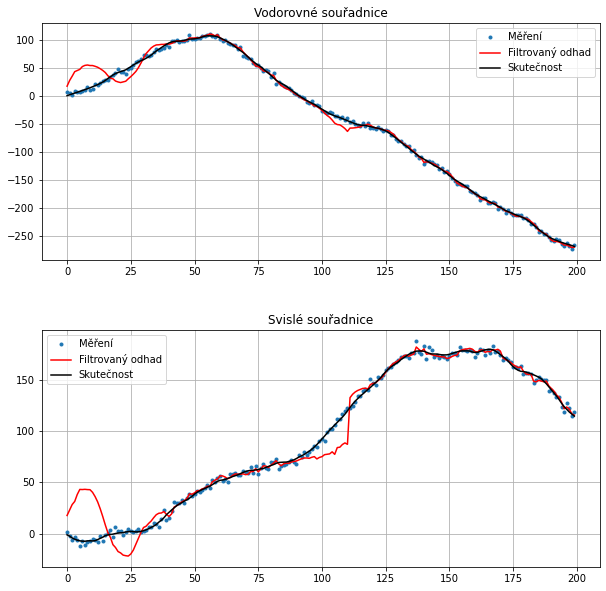

In [116]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Vodorovné souřadnice')
plt.plot(traj.Y[0,:], '.', label='Měření')
plt.plot(log_x[0,:], '-', color='red', label='Filtrovaný odhad')
plt.plot(traj.X[0,:], 'k', label='Skutečnost')
plt.grid(True)
plt.legend()
plt.subplot(2,1,2)
plt.title('Svislé souřadnice')
plt.plot(traj.Y[1,:], '.', label='Měření')
plt.plot(log_x[1,:], '-', color='red', label='Filtrovaný odhad')
plt.plot(traj.X[1,:], 'k', label='Skutečnost')
plt.grid(True)
plt.legend()
plt.show()

**3. Rychlost v jednotlivých souřadnicích**

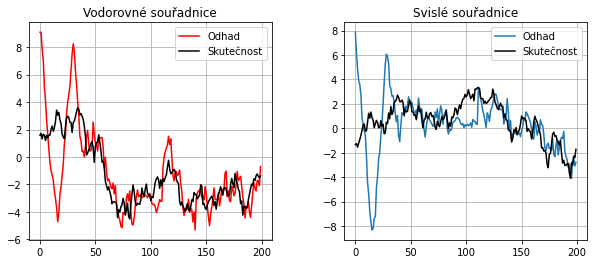

In [117]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.title('Vodorovné souřadnice')
plt.plot(log_x[2,:], 'r', label='Odhad')
plt.plot(traj.X[2,:], 'k', label='Skutečnost')
plt.legend()
plt.subplot(1,2,2)
plt.title('Svislé souřadnice')
plt.plot(log_x[3,:], label='Odhad')
plt.plot(traj.X[3,:], 'k', label='Skutečnost')
plt.legend()
plt.show()

**Úkoly:**
- zkuste posadit počáteční particly mimo (např. do [10,...,10])
- vysledujte, co se stane, pokud se mění množství particlů
- zkuste nasimulovat výpadek měření